In [1]:
import pandas as pd
import bt
import time
import os
import h5py

In [2]:
data = bt.get(
    'aapl,msft,c,gs,ge',
    start='2010-01-01',
    end = '2022-07-01'
)
data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,aapl,msft,c,gs,ge
Date,,,,,
2010-01-04,6.478999,23.474918,26.893297,136.536926,67.992668
2010-01-05,6.490200,23.482500,27.921581,138.950943,68.344711
2010-01-06,6.386965,23.338398,28.791649,137.467804,67.992668
2010-01-07,6.375157,23.095676,28.870752,140.157883,71.513283
2010-01-08,6.417541,23.254967,28.396152,137.507278,73.053581
...,...,...,...,...,...
2022-06-24,140.444229,264.041077,44.782074,289.352966,52.030643
2022-06-27,140.444229,261.269501,44.754005,287.470184,51.805439
2022-06-28,136.260391,252.974411,44.173874,286.237274,51.160873


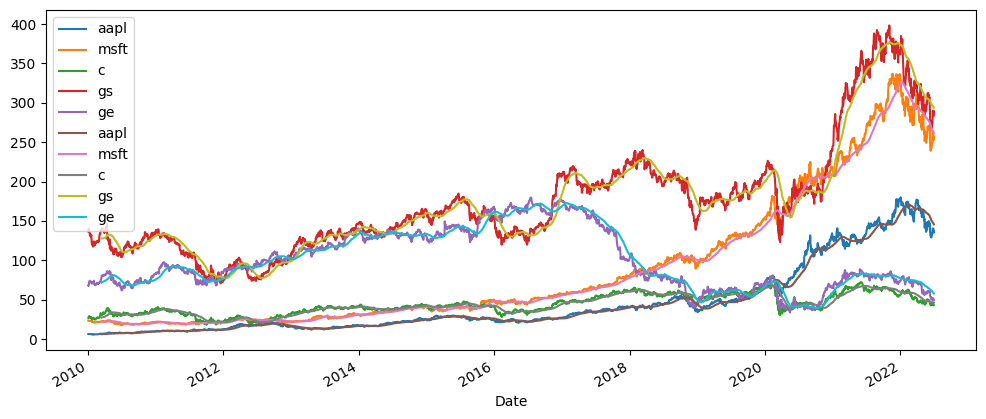

In [3]:
sma = data.rolling(50).mean()

plot = bt.merge(data, sma).plot(figsize=(12, 5))

In [4]:
st = time.time()
class SelectWhere(bt.Algo):

    """
    Selects securities based on an indicator DataFrame.

    Selects securities where the value is True on the current date (target.now).

    Args:
        * signal (DataFrame): DataFrame containing the signal (boolean DataFrame)

    Sets:
        * selected

    """
    def __init__(self, signal):
        self.signal = signal

    def __call__(self, target):
        # get signal on target.now
        if target.now in self.signal.index:
            sig = self.signal.loc[target.now]

            # get indices where true as list
            selected = list(sig.index[sig])

            # save in temp - this will be used by the weighing algo
            target.temp['selected'] = selected

        # return True because we want to keep on moving down the stack
        return True
    
signal = data > sma


# first we create the Strategy
s = bt.Strategy('above50sma', [SelectWhere(data > sma),
                               bt.algos.WeighEqually(),
                               bt.algos.Rebalance()])

# now we create the Backtest
t = bt.Backtest(s, data)

# and let's run it!
res = bt.run(t)
et = time.time()

print(f"Run time: {et-st:.2f} seconds") 


Run time: 0.67 seconds


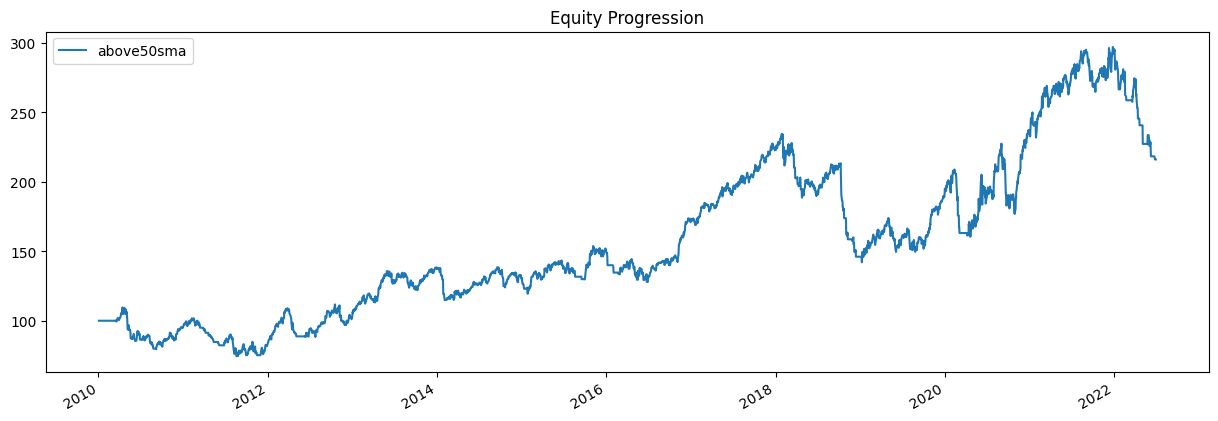

In [5]:
# what does the equity curve look like?
res.plot();

In [6]:
res.display()

Stat                 above50sma
-------------------  ------------
Start                2010-01-03
End                  2022-06-30
Risk-free rate       0.00%

Total Return         116.08%
Daily Sharpe         0.42
Daily Sortino        0.63
CAGR                 6.36%
Max Drawdown         -39.43%
Calmar Ratio         0.16

MTD                  -7.41%
3m                   -20.85%
6m                   -26.49%
YTD                  -26.03%
1Y                   -22.21%
3Y (ann.)            10.35%
5Y (ann.)            2.34%
10Y (ann.)           8.71%
Since Incep. (ann.)  6.36%

Daily Sharpe         0.42
Daily Sortino        0.63
Daily Mean (ann.)    8.08%
Daily Vol (ann.)     19.45%
Daily Skew           -0.65
Daily Kurt           4.74
Best Day             5.78%
Worst Day            -8.26%

Monthly Sharpe       0.39
Monthly Sortino      0.65
Monthly Mean (ann.)  8.65%
Monthly Vol (ann.)   21.93%
Monthly Skew         -0.37
Monthly Kurt         0.70
Best Month           21.65%
Worst Month         

In [38]:
# convert index to epoch time
data_atlas = data.copy()
data_atlas.index = data_atlas.index.astype('int64')

# split columns into indivual dataframes
dfs = {col: pd.DataFrame(data_atlas[col]) for col in data_atlas}

output_path = os.path.join(os.getcwd(), 'data_sp500.h5')
if os.path.exists(output_path):
    os.remove(output_path)


with h5py.File(output_path, "a") as file:
    for ticker, df in dfs.items():
        #rename ticker column to "close"
        df.columns = ["close"]
        df["50_ma"] = sma[ticker].values
        df.dropna(inplace = True)
        stock_data = df.to_numpy()
        index = df.index.map(lambda timestamp: int(timestamp)).to_numpy()
        print(ticker, len(index))

        dataset = file.create_dataset(f"{ticker}/data", data=stock_data)
        file.create_dataset(
                f"{ticker}/datetime",
                data = index,
        )
        for column in df.columns:
            dataset.attrs[column] = column

aapl 3096
msft 3096
c 3096
gs 3096
ge 3096


In [27]:
sma["aapl"]

Date
2010-01-04           NaN
2010-01-05           NaN
2010-01-06           NaN
2010-01-07           NaN
2010-01-08           NaN
                 ...    
2024-01-08    187.636195
2024-01-09    188.005586
2024-01-10    188.369413
2024-01-11    188.679894
2024-01-12    188.987388
Name: aapl, Length: 3531, dtype: float64

In [29]:
dfs["aapl"]

,close,50_ma
Date,,
1268697600000000000,6.795063,6.265486
1268784000000000000,6.785070,6.271607
1268870400000000000,6.801117,6.277826
1268956800000000000,6.728458,6.284655
1269216000000000000,6.804146,6.293235
...,...,...
1704672000000000000,185.559998,187.636195
1704758400000000000,185.139999,188.005586
1704844800000000000,186.190002,188.369413
